In [ ]:
%pip install -q pennylane pennylane-lightning scikit-learn pyarrow

import pennylane as qml
from pennylane import numpy as np
import numpy as onp

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

READY = Path("../data/ready") 


Note: you may need to restart the kernel to use updated packages.


In [ ]:
file = "HI_Small_ready.parquet"     

label_col = "Is Laundering"
X_all = df.drop(columns=[label_col])
y_all = df[label_col].astype(int)


num_cols = X_all.var().sort_values(ascending=False).head(6).index.tolist()
n_qubits = len(num_cols)
print("Using features:", num_cols, "| qubits:", n_qubits)


X_small, _, y_small, _ = train_test_split(
    X_all[num_cols], y_all, train_size=8000, stratify=y_all, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_small.values.astype("float32"),
    y_small.values.astype(int),
    test_size=0.2,
    stratify=y_small,
    random_state=42,
)

print("Train/Val sizes:", X_train.shape, X_val.shape)


Using features: ['acct_from_min', 'acct_from_mean', 'weekday', 'Amount Paid', 'acct_from_count', 'acct_from_sum'] | qubits: 6
Train/Val sizes: (6400, 6) (1600, 6)


In [ ]:
try:
    dev = qml.device("lightning.qubit", wires=n_qubits)
except Exception:
    dev = qml.device("default.qubit", wires=n_qubits)

def feature_encoder(x):
    """Angle (RY) encoding of real-valued features."""
    qml.templates.AngleEmbedding(x, wires=range(n_qubits), rotation="Y")

def variational_block(weights):
    """A small entangling block."""
    for w, w_idx in zip(weights["rot"], range(n_qubits)):
        qml.Rot(*w, wires=w_idx)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])
    for w, w_idx in zip(weights["rot2"], range(n_qubits)):
        qml.RY(w, wires=w_idx)

def init_weights(seed=0):
    rng = onp.random.default_rng(seed)
    return {
        "rot":  rng.normal(0, 0.1, size=(n_qubits, 3)), 
        "rot2": rng.normal(0, 0.1, size=(n_qubits,)),
        "bias": onp.array(0.0)
    }

@qml.qnode(dev, interface="autograd")
def qnode(x, weights):
    feature_encoder(x)
    variational_block(weights)
    return qml.expval(qml.PauliZ(wires=n_qubits - 1))

def predict_proba_batch(X, weights):
    outs = [qnode(x, weights) for x in X]
    outs = onp.array(outs, dtype="float64")
    logits = -outs  
    return 1.0 / (1.0 + onp.exp(-3.0 * logits))  


In [ ]:
def bce_loss(y_true, p_pred, eps=1e-8):
    p = onp.clip(p_pred, eps, 1-eps)
    return -(y_true*onp.log(p) + (1-y_true)*onp.log(1-p)).mean()

def batch_iter(X, y, batch=64, shuffle=True, seed=42):
    N = len(y)
    idx = onp.arange(N)
    if shuffle:
        rng = onp.random.default_rng(seed)
        rng.shuffle(idx)
    for i in range(0, N, batch):
        sel = idx[i:i+batch]
        yield X[sel], y[sel]

weights = init_weights(seed=1)
opt_lr = 0.05
epochs = 15
batch = 64

for ep in range(1, epochs+1):
    tr_losses = []
    for Xb, yb in batch_iter(X_train, y_train, batch=batch, shuffle=True, seed=ep):
        pb = predict_proba_batch(Xb, weights)
        loss = bce_loss(yb, pb)

        grads = {k: onp.zeros_like(v) for k, v in weights.items()}
        eps = 1e-3

        for key in ["rot", "rot2"]:
            w = weights[key]
            it = onp.nditer(w, flags=["multi_index"])
            while not it.finished:
                idx = it.multi_index
                old = w[idx]
                w[idx] = old + eps
                l_plus = bce_loss(yb, predict_proba_batch(Xb, weights))
                w[idx] = old - eps
                l_minus = bce_loss(yb, predict_proba_batch(Xb, weights))
                w[idx] = old
                grads[key][idx] = (l_plus - l_minus) / (2*eps)
                it.iternext()

        old = weights["bias"]
        weights["bias"] = old + eps
        l_plus = bce_loss(yb, predict_proba_batch(Xb, weights))
        weights["bias"] = old - eps
        l_minus = bce_loss(yb, predict_proba_batch(Xb, weights))
        weights["bias"] = old
        grads["bias"] = (l_plus - l_minus) / (2*eps)

        weights["rot"]  -= opt_lr * grads["rot"]
        weights["rot2"] -= opt_lr * grads["rot2"]
        weights["bias"] -= opt_lr * grads["bias"]

        tr_losses.append(float(loss))

    p_val = predict_proba_batch(X_val, weights)
    auc = roc_auc_score(y_val, p_val)
    print(f"Epoch {ep:02d} | train_loss={onp.mean(tr_losses):.4f} | val_auc={auc:.3f}")


Epoch 01 | train_loss=0.7799 | val_auc=0.632
Epoch 02 | train_loss=0.6775 | val_auc=0.621
Epoch 03 | train_loss=0.6742 | val_auc=0.620
Epoch 04 | train_loss=0.6733 | val_auc=0.619
Epoch 05 | train_loss=0.6732 | val_auc=0.620
Epoch 06 | train_loss=0.6730 | val_auc=0.619
Epoch 07 | train_loss=0.6731 | val_auc=0.621
Epoch 08 | train_loss=0.6729 | val_auc=0.621
Epoch 09 | train_loss=0.6729 | val_auc=0.621
Epoch 10 | train_loss=0.6730 | val_auc=0.621


KeyboardInterrupt: 

ROC-AUC: 0.61936875
              precision    recall  f1-score   support

           0     0.5733    0.7825    0.6617       800
           1     0.6575    0.4175    0.5107       800

    accuracy                         0.6000      1600
   macro avg     0.6154    0.6000    0.5862      1600
weighted avg     0.6154    0.6000    0.5862      1600



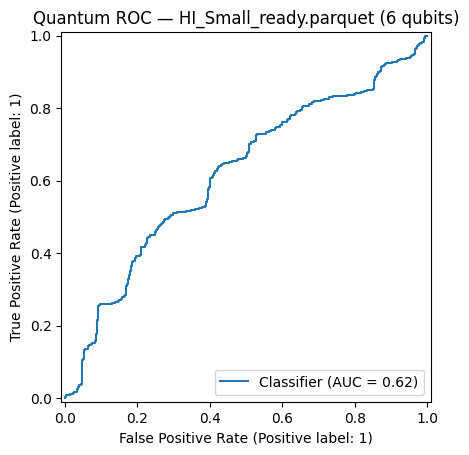

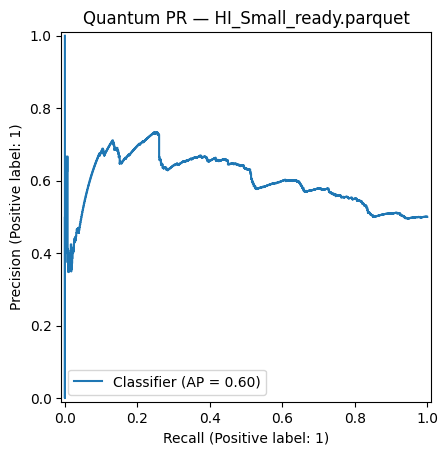

In [6]:
p_val = predict_proba_batch(X_val, weights)
y_pred = (p_val >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_val, p_val))
print(classification_report(y_val, y_pred, digits=4))

RocCurveDisplay.from_predictions(y_val, p_val)
plt.title(f"Quantum ROC — {file} ({n_qubits} qubits)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_val, p_val)
plt.title(f"Quantum PR — {file}")
plt.show()


In [ ]:
vec = X_all.var().sort_values(ascending=False).head(8).index
x = X_all[vec].iloc[0].values.astype("float64")
x = x / onp.linalg.norm(x)  

dev_amp = qml.device("default.qubit", wires=3)

@qml.qnode(dev_amp)
def amp_embed(x):
    qml.AmplitudeEmbedding(x, wires=[0,1,2], normalize=False)
    return [qml.state()]

state = amp_embed(x)
print("State vector length:", len(state[0]))


State vector length: 8
